# Implementation of 2D Convolutional Neural Network

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Downloading Dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


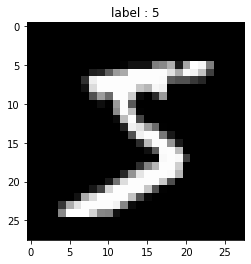

In [3]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

# Preprocessing

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

print(y_test_one_hot.shape) # (60000, 10)

1.0
0.0
(60000,)
(60000, 10)
float64
(10000, 10)


# Divide into training data and test data

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape) # (12000, 784)

(48000, 1, 28, 28) (48000, 10)
(12000, 1, 28, 28) (12000, 10)


# Problem 3
## Calculation of output size after one-dimensional convolution

In [6]:
def calc_out_shape(N_in, P, F, S):
  N_out = ((N_in + 2 * P - F) / S) + 1
  return int(N_out)

In [7]:
N_in = 3 #(height, width)
P = 0
F = 2
S = 1

print("out size:", calc_out_shape(N_in, P, F, S))

out size: 2


In [8]:
## Problem 1 Creation of a two-dimensional convolution layer
## Let's create a class of 2D convolution layers. Just extend from the 1dCNN implementation to 2D.


class Conv2d:
    def __init__(self, activation, optimizer, filter_num, input_channel, filter_size, stride=1, pad=0):
        self.stride = stride
        self.pad = pad
        
        self.activation = activation
        self.optimizer = optimizer
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
        if self.activation == 'sigmoid':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)            
        elif self.activation == 'tanh':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)          
        elif self.activation == 'relu':
            initializer = HeInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)        
        
        ## Intermediate data (used during backward)
        self.x = None   
        self.col = None
        self.col_W = None
        
        ## Gradient of weight / bias parameters
        self.dW = None
        self.db = None

    def _calc_out_shape(self, H, FH, W, FW):
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        return out_h, out_w

    def _im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
         ----------
         input_data: Input data consisting of a 4-dimensional array of (number of data, channels, height, width)
         filter_h: Filter height
         filter_w: Filter width
         stride: stride
         pad: padding
         Returns
         -------
         col: 2D array
        """
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        
        return col

    def _col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
         ----------
         col:
         input_shape: Shape of input data (example: (10, 1, 28, 28))
         filter_h:
         filter_w
         stride
         pad
         Returns
         -------
        """
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape ##Filters (FN: number of filters, C: number of channels, FH: filter height, FW: filter width)
        N, C, H, W = x.shape ##Input data (N: number of batches, C: number of channels, H: height, W: width)
        
        ## Output size after 2D convolution (h: height, w: width)
        out_h, out_w = self._calc_out_shape(H, FH, W, FW)

        ## Expansion of 4D data to 2D by im2col
        col = self._im2col(x, FH, FW, self.stride, self.pad)
        
        col_W = self.W.reshape(FN, -1).T ## Transpose of filter
        out = np.dot(col, col_W) + self.b ## Convolution operation
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) ## Output size formatting

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)    
        dx = self._col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

# Problem 4
## Creation of maximum pooling layer

In [10]:
class MaxPool2D:
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def _im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
       Parameters
         ----------
         input_data: Input data consisting of a 4-dimensional array of (number of data, channels, height, width)
         filter_h: Filter height
         filter_w: Filter width
         stride: stride
         pad: padding
         Returns
         -------
         col: 2D array
        """
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        
        return col
        
    def _col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        """
       Parameters
         ----------
         col:
         input_shape: Shape of input data (example: (10, 1, 28, 28))
         filter_h:
         filter_w
         stride
         pad
         Returns
         -------
        """
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
                
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = self._im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self._col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# Problem 5
## Smoothing

In [11]:
class Flatten():
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        ## One-dimensional
        X_1d = X.reshape(X.shape[0], -1)
        
        ## Record of shape
        self.X_shape = X.shape
        
        return X_1d    

    def backward(self, X):
        ## Return of shape
        X = X.reshape(self.X_shape)
        
        return X


# Problem 6
## Learning and estimation

In [12]:
class GetMiniBatch:
    """
   Iterator to get a mini-batch

     Parameters
     ----------
     X: ndarray, shape (n_samples, n_features) of the following form
       Training data
     y: ndarray of the following form, shape (n_samples, 1)
       Correct answer value
     batch_size: int
       Batch size
     seed: int
       NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


In [46]:
class Scratch2dCNNClassifier:
    """
    Deep neural network classifier

     Parameters
     --------------
     activaiton: {'sigmoid','tanh','relu'}
         Types of activation functions
     n_nodes: list
         Node configuration example [400, 200, 100]
     n_output: int
         Number of output layers
     alpha: float
         Learning rate
     optimizer: {'sgd','adagrad'}
         Types of optimization methods
     filter_num: int
         Number of filters
     filter_size: int
         Filter size
     stride: int (initial value: 1)
         stride
     pad: int (initial value: 0)
         Padding
        
    Attributes
     -------------
     FC [n_layers]: dict
         A dictionary that manages the connection layer
     activation: dict
         A dictionary that manages the activation function
     self.epochs: int
         Number of epochs (initial value: 10)
     self.batch_size: int
         Batch size (initial value: 20)
     self.n_features: int
         Number of features
     self.val_is_true: boolean
         Presence or absence of verification data
     self.loss: empty ndarray
         Record losses on training data
     self.loss_val: empty ndarray
         Record loss on validation data       
    """    
    def __init__(self, activation, n_nodes, n_output, lr, optimizer, filter_num, filter_size):
        self.select_activation = activation
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
        
        self.filter_num  = filter_num    ## Number of filters
        self.filter_size   = filter_size    ## Filter size        
        self.stride          = 1               ##stride
        self.pad             = 0               ##Padding
            
    def _initialize_n_layers(self):
        """
        Initialize the N layer.
         When the sigmoid function and tanh function are activation functions: Xavier is the initial value
         If the ReLU function is an activation function: He is the initial value
        """
        self.activation = dict()
        self.FC = dict()
        ##Instantiation of FC class that connects the pooling layer to the fully connected layer
        if self.select_activation == 'sigmoid':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Sigmoid()
        elif self.select_activation == 'tanh':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Tanh()
        elif self.select_activation == 'relu':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = ReLU()

        ##Instantiation of FC class between fully coupled layers
        for n_layer in range(len(self.n_nodes)):            
            if n_layer == len(self.n_nodes) -1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output, 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1], 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
                    
    def _calc_out_shape(self, H, FH, W, FW, layer):
        """
        A function that calculates the output size of the Convolution and Pooling layers
        """        
        if layer == 'conv':
            out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
            out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = int(1 + (H - FH) / self.stride)
            out_w = int(1 + (W - FW) / self.stride)
        
        return out_h, out_w    
    
    def fit(self, X, y, epochs=10, batch_size=20):  
        self.epochs = epochs                            ## Number of epochs    
        self.batch_size = batch_size               ## Batch size
        self.loss = np.zeros(self.epochs)        ## For output of learning curve / objective function (training data)
        self.loss_val = np.zeros(self.epochs) ## For output of learning curve / objective function (verification data)        
        
        ##Instantiation of optimization class
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        ##Input data shape
        self.input_channel = X.shape[1]
        self.input_h = X.shape[2]
        self.input_w = X.shape[3]
        
        ##Instantiation of convolution layer class
        self.conv = Conv2d(self.select_activation, self.optimizer, self.filter_num, self.input_channel, self.filter_size)
        
        ##Instantiation of activation function class
        if self.select_activation == 'sigmoid':
            self.activation_conv = Sigmoid()
        elif self.select_activation == 'tanh':
            self.activation_conv = Tanh()
        elif self.select_activation == 'relu':
            self.activation_conv = ReLU()
            
        ##Instantiation of pooling layer class
        self.pool = MaxPool2D()   

        ## Instantiation of smoothing class
        self.flatten = Flatten()

        ##Size before full connection
        out_h, out_w = self._calc_out_shape(self.input_h, self.filter_size, self.input_w, self.filter_size, 'conv')
        out_h, out_w = self._calc_out_shape(out_h, self.filter_size, out_w, self.filter_size, 'pool')
        self.out_size = out_h * out_w * self.filter_num
        
        ##Initialization of N layer
        self._initialize_n_layers()
        
        ##Get a mini-batch
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)
        
        for epoch in range(self.epochs):
            print("epoch ", epoch + 1 , " processing . . .")
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                ##Forward propagation
                ##Convolution layer
                self.A = self.conv.forward(self.X_)
                ##Activation function
                self.Z = self.activation_conv.forward(self.A)
                ##Pooling layer
                self.P = self.pool.forward(self.Z)
                ##Smoothing
                self.F = self.flatten.forward(self.P)
                
                self.A = self.FC[0].forward(self.F)
                self.Z = self.activation[0].forward(self.A)       
                for n_layer in range(1, len(self.n_nodes) + 1):
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                ##Backpropagation
                self.dA, self.loss[epoch] = self.activation[len(self.n_nodes)].backward(self.Z, self.y_) ##Final layer, cross entropy error                self.dZ = self.FC[len(self.n_nodes)].backward(self.dA) #最終層
                for n_layer in reversed(range(0, len(self.n_nodes))): ##Final layer -1
                    self.dA = self.activation[n_layer].backward(self.dZ)
                    self.dZ = self.FC[n_layer].backward(self.dA)

                ##Return of shape
                self.dF = self.flatten.backward(self.dZ)
                
                ##Pooling layer
                self.dP = self.pool.backward(self.dF)
                ##Activation function
                self.dA = self.activation_conv.backward(self.dP)
                ##Convolution layer
                self.dZ = self.conv.backward(self.dA)
                
    def predict(self,X):
        ## Forward propagation
        ##Convolution
        self.A = self.conv.forward(X)
        ##Activation function
        self.Z = self.activation_conv.forward(self.A)
        ##Pooling layer
        self.P = self.pool.forward(self.Z)
        ##Smoothing
        self.F = self.flatten.forward(self.P)

        self.A = self.FC[0].forward(self.F)
        self.Z = self.activation[0].forward(self.A)    
        for n_layer in range(1, len(self.n_nodes) + 1):
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

In [47]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
     Parameters
     ----------
     n_nodes1: int
       Number of nodes in the previous layer
     n_nodes2: int
       Number of nodes in the later layer
     initializer: instance of initialization method
     optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        ## Initialization
         ## Initialize self.W and self.B using the initialr method
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):
        """
        forward
         Parameters
         ----------
         X: ndarray, shape (batch_size, n_nodes1) of the following form
             input
         Returns
         ----------
         A: ndarray, shape (batch_size, n_nodes2) of the following form
             output        """        
        self.X = X
        
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        """
       Backward
         Parameters
         ----------
         dA: ndarray, shape (batch_size, n_nodes2) of the following form
             Gradient flowing from behind
         Returns
         ----------
         dZ: ndarray, shape (batch_size, n_nodes1) of the following form
             Gradient to flow forward
        """
        self.dB = dA
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

       ## Update
        self = self.optimizer.update(self)
        
        return dZ

In [48]:
class XavierInitializer:
    """
    Xavier class
    """
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size 
        
    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
         Parameters
         ----------
         n_nodes1: int
           Number of nodes in the previous layer
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         W: ndarray, shape (n_nodes1, n_nodes2) of the following form
             weight
        """     
        if self.filter_num and self.input_channel and self.filter_size is not None: ## Convolution layer
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size)
        else: ## Fully connected layer
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)       
        
        return W
        
    def B(self, n_nodes2):
        """
        Bias initialization
         Parameters
         ----------
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         B: ndarray, shape (n_nodes2,) of the following form
             bias
        """       
        if self.filter_num and self.input_channel and self.filter_size is not None: ## Convolution layer
            B = np.random.randn(self.filter_num)
        else: ## Fully connected layer
            B = np.zeros(n_nodes2)
        
        return B


In [49]:
class HeInitializer:
    """
   He class
    """
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size       
        
    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
         Parameters
         ----------
         n_nodes1: int
           Number of nodes in the previous layer
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         W: ndarray, shape (n_nodes1, n_nodes2) of the following form
             weight
        """      
        if self.filter_num and self.input_channel and self.filter_size is not None: ## Convolution layer
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size) * np.sqrt(2 / self.filter_num) 
        else: ## Fully connected layer
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        Bias initialization
         Parameters
         ----------
         n_nodes2: int
           Number of nodes in the later layer

         Returns
         ----------
         B: ndarray, shape (n_nodes2,) of the following form
             bias
        """      
        if self.filter_num and self.input_channel and self.filter_size is not None: ## Convolution layer
            B = np.random.randn(self.filter_num)
        else: ## Fully connected layer
            B = np.random.randn(n_nodes2)
        
        return B

In [50]:
class SGD:
    """
    Stochastic gradient descent
     Parameters
     ----------
     lr: Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        Update weights and biases for a layer
         Parameters
         ----------
         layer: Instance of the layer before update
        
         Returns
         ----------
         layer: Updated layer instance
        """
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer

In [51]:
class AdaGrad:
    """
    AdaGrad class
     Parameters
     ----------
     alpha: Learning rate
    
     Attributes
     -------------
     lr: Learning rate
     HW: int (initial value), ndarray
     HB: int (initial value), ndarray
    """    
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0 ## Initial value: 0
        self.HB = 0 ## Initial value: 0      

    def update(self, layer):
        """
        Update weights and biases for a layer
         Parameters
         ----------
         layer: instance
             Instance of the layer before update

         Returns
         ----------
         layer: instance
             Updated tier instance
        """
        ## Initialization
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        
        ## update
        self.HW = self.HW + (layer.dW**2) #/ layer.dB.shape[0]
        self.HB = self.HB + (layer.dB**2).mean(axis=0)
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW #/ layer.dB.shape[0]
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB.mean(axis=0)
        
        return layer


In [52]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        self.Z = 1.0 / (1.0 + np.exp(-self.A))
        
        return self.Z
    
    def backward(self, dZ):

        return dZ * (1 - self.Z) * self.Z

In [53]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        return np.tanh(self.A)
    
    def backward(self, dZ):
        
        return dZ * (1.0 - (np.tanh(self.A) ** 2))

In [54]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, A):    
        self.A = A
      
        return np.maximum(self.A, 0)
    
    def backward(self, dZ):
            
        return np.where(self.A > 0, dZ, 0)

In [55]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    
    def backward(self, Z, y):
        
        dA = Z - y
        
        ## Cross entropy error
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(Z)) / batch_size

        return dA, loss

In [56]:
model = Scratch2dCNNClassifier(activation='relu', n_nodes=[400, 200, 100], n_output=10, lr=0.001, optimizer='sgd', filter_num=3, filter_size=3)
model.fit(X_train, y_train, epochs=10, batch_size=20)
y_pred = model.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .
epoch  4  processing . . .
epoch  5  processing . . .
epoch  6  processing . . .
epoch  7  processing . . .
epoch  8  processing . . .
epoch  9  processing . . .
epoch  10  processing . . .


In [57]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.9746


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.96      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Problem 8 (advanced task) 
## LeNet

In [58]:
import os
import keras
from keras import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.datasets import mnist
from keras.callbacks import TensorBoard

In [74]:
def lenet(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(6, kernel_size=5, strides=(1, 1), input_shape=input_shape, activation="relu"))
  model.add(Conv2D(16, kernel_size=5, strides=(1, 1), activation="relu"))
  model.add(Flatten())
  model.add(Dense(120, activation="relu") )
  model.add(Dense(84, activation="relu"))
  model.add(Dense(num_classes, activation="softmax"))
  return model

In [75]:
class MNISTDataset():
  def __init__(self):
    self.image_shape = (28, 28, 1)
    self.num_classes = 10

  def get_batch(self):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train, X_test = [self.preprocess(d) for d in [X_train, X_test]]
    y_train, y_test = [self.preprocess(d, label_data=True) for d in [y_train, y_test]]
    return X_train, y_train, X_test, y_test

  def preprocess(self, data, label_data=False):
    if label_data:
      data = keras.utils.to_categorical(data, self.num_classes)
    else:
      data = data.astype("float32") / 255
      shape = (data.shape[0],) + self.image_shape
      data = data.reshape(shape)
    return data

In [76]:
class Trainer():
  def __init__(self, model, loss, optimizer, logdir="logdir"):
    self.target = model
    self.target.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    self.verbose = 1
    self.log_dir = os.path.join(os.path.dirname(__file__), logdir)
    if not os.path.exists(self.log_dir):
      os.mkdir(self.log_dir)

  def train(self, X_train, y_train, batch_size, epochs, validation_split):
    self.target.fit(X_train, y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[TensorBoard(log_dir=self.log_dir)],
                    verbose=self.verbose)

In [77]:
try:
    __file__
except NameError:
    __file__ = os.path.join(os.getcwd(),"dummy")
else:
    pass

In [78]:
dataset = MNISTDataset()

model = lenet(dataset.image_shape, dataset.num_classes)

X_train, y_train, X_test, y_test = dataset.get_batch()
trainer = Trainer(model, loss="categorical_crossentropy", optimizer="adam", logdir="logdir32")
trainer.train(X_train, y_train, batch_size=128, epochs=12, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/12
  1/375 [..............................] - ETA: 11s - loss: 2.3112 - accuracy: 0.0938WARNING:tensorflow:From C:\Users\Andrew\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
375/375 [==============================] - 44s 118ms/step - loss: 0.2226 - accuracy: 0.9342 - val_loss: 0.0887 - val_accuracy: 0.9737
Epoch 2/12
375/375 [==============================] - 40s 108ms/step - loss: 0.0627 - accuracy: 0.9810 - val_loss: 0.0605 - val_accuracy: 0.9828
Epoch 3/12
375/375 [==============================] - 40s 108ms/step - loss: 0.0412 - accuracy: 0.9872 - val_loss: 0.0508 - val_accuracy: 0.9846
Epoch 4/12
375/375 [==============================] - 41s 108ms/step - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0496 - val_accuracy: 0.9851
Epoch 5/12
375/375 [==============================] 

In [80]:
%load_ext tensorboard
%tensorboard --logdir logdir32
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11252), started 0:00:11 ago. (Use '!kill 11252' to kill it.)

# Problem 9 (Advance task) 
## Survey of famous image recognition models

When building a CNN model, it is necessary to calculate in advance the number of features at the stage of input to the all-connected layer. In addition, when dealing with large models, the calculation of the number of parameters becomes a necessity due to memory and computation speed. The framework can show you the number of parameters for each layer, but you need to understand the meaning to be able to adjust it properly.

Calculate the output size and the number of parameters for the following three convolutional layers. For the number of parameters also consider the bias term.

1. input size : 144×144, 3 channels filter size : 3×3, 6 channels stride : 1 padding : none

2. input size : 60 x 60, 24 channels filter size : 3 x 3, 48 channels stride : 1 padding : none

3. input size : 20x20, 10 channels filter size : 3x3, 20 channels stride : 2 padding : none

The last example is a case where the convolution cannot be done just right. The last example is a case where the convolution can't be done just right, the framework may not see the extra pixels. This is an example of why such a setting is undesirable, as it will result in missing edges.

1. input size : 144×144, 3 channels filter size : 3×3, 6 channels stride : 1 padding : none
Answer Output size = 141 x 141 Number of parameters = 6 (number of output filters) x 3 (number of kernels) x 3 x 3 Bias term = 6

1. input size : 60×60, 24 channels filter size : 3×3, 48 channels stride : 1 padding : none
Answer Output size = 58 x 58 Number of parameters = 48 (number of output filters) x 24 (number of kernels) x 3 x 3 Bias term = 48

1. input size : 20×20, 10 channels filter size : 3×3, 20 channels stride : 2 padding : none
Answer Output size = 10 x 10 Number of parameters = 20 (number of output filters) x 10 (number of kernels) x 3 x 3 Bias term = 20

# Problem 10 
## Calculation of output size and number of parameters

In [82]:
def calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN):
    out_h = int(1 + (H + 2*pad - FH) / stride)
    out_w = int(1 + (W + 2*pad - FW) / stride)
    
    params = FH * FW * IC * FN + FN ## Finally add the bias term + FN
        
    activation_size = FN * out_h * out_w
        
    return out_h, out_w, params, activation_size

Input size: 144 x 144, 3 channels


Filter size: 3 x 3, 6 channels


Stride: 1


Padding: None

In [84]:
##Input size
H, W, IC = (144, 144, 3) # IC = input_channel

##Filter size
FH, FW, FC = (3, 3, 3) ## FC (unused)= filter_channel

##Number of filters (The filter size of 6 channels specified in the problem is assumed to be the number of filters)
FN = 6

##Stride, padding
stride, pad = 1, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('Output size(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('Number of parameters : {}'.format(params))

Output size(FN × OH × OW) : 6 × 142 × 142
Activation Size : 120984
Number of parameters : 168


Input size: 60 x 60, 24 channels


Filter size: 3 x 3, 48 channels


Stride: 1


Padding: None

In [86]:
##Input size
H, W, IC = (60, 60, 24) ## IC = input_channel

##Filter size
FH, FW, FC = (3, 3, 24) ## FC(unused) = filter_channel

##Number of filters (The problem-specified filter size of 48 channels is assumed to be the number of filters)
FN = 48

##Stride, padding
stride, pad = 1, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('Output size(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('Number of parameters : {}'.format(params))

Output size(FN × OH × OW) : 48 × 58 × 58
Activation Size : 161472
Number of parameters : 10416


Input size: 20 x 20, 10 channels


Filter size: 3 x 3, 20 channels


Stride: 2


Padding: None

In [88]:
##Input size
H, W, IC = (20, 20, 10) ## IC = input_channel

##Filter size
FH, FW, FC = (3, 3, 10) ## FC(unused) = filter_channel

##Number of filters (The 20-channel filter size specified in the problem is assumed to be the number of filters)
FN = 20

##Stride, padding
stride, pad = 2, 0

out_h, out_w, params, activation_size = calc_out_shape_and_params(H, FH, W, FW, pad, stride, IC, FN)

print('Output size(FN × OH × OW) : {} × {} × {}'.format(FN, out_h, out_w))
print('Activation Size : {}'.format(activation_size))
print('Number of parameters : {}'.format(params))

Output size(FN × OH × OW) : 20 × 9 × 9
Activation Size : 1620
Number of parameters : 1820


Output size (FN x OH x OW): 20 x 9 x 9

    
Activation Size: 1620

    
Number of parameters: 1820